**Reference**
* 李宏毅 Machine Learning 2020 Hw1
* https://colab.research.google.com/drive/131sSqmrmWXfjFZ3jWSELl8cm0Ox5ah3C

# **Load 'train.csv'**

train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [ ]:
import sys
import pandas as pd
import numpy as np
data = pd.read_csv('/kaggle/input/week8data/train.csv', encoding = 'big5')

# **Preprocessing**

取需要的數值部分，將 'RAINFALL' 欄位全部補 0。 另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [ ]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

# **Extract Features (1)**

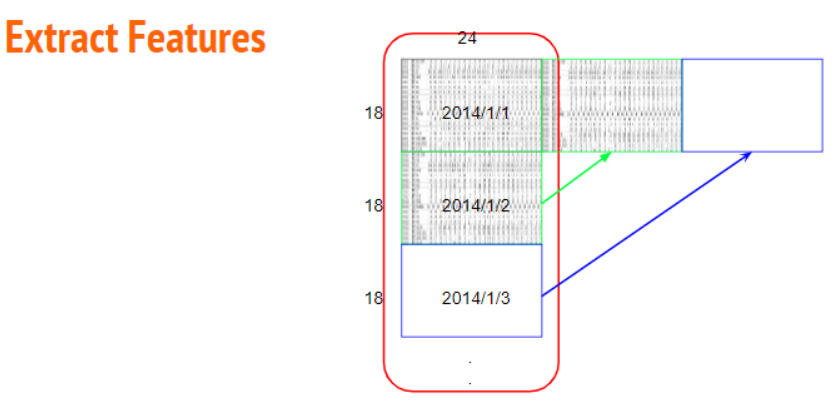

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。

In [ ]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**

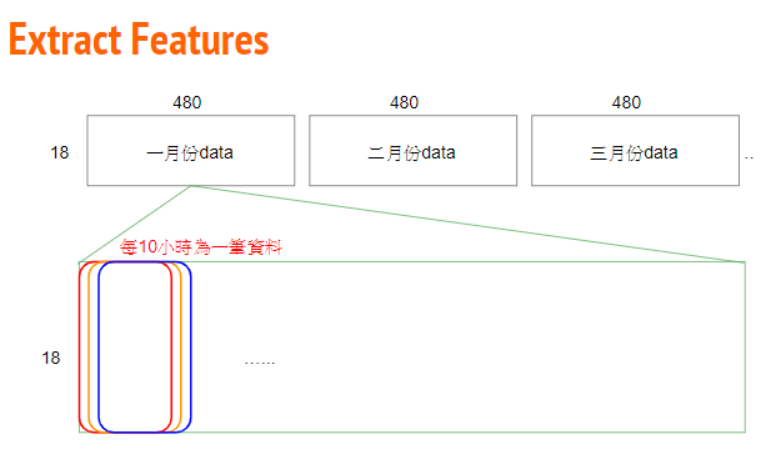

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [ ]:
x = np.empty([12 * 471, 1 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][9,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
print(x)
print(y)

# **Normalize (1)**

In [ ]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

# **Training**

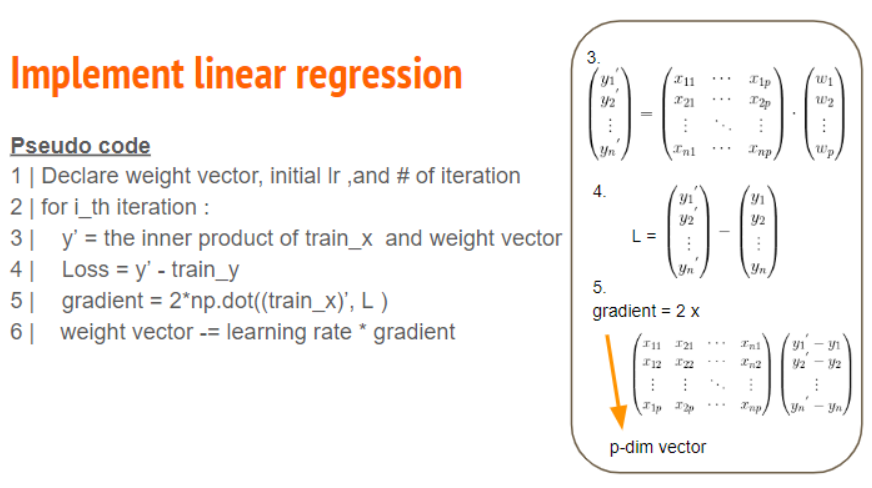

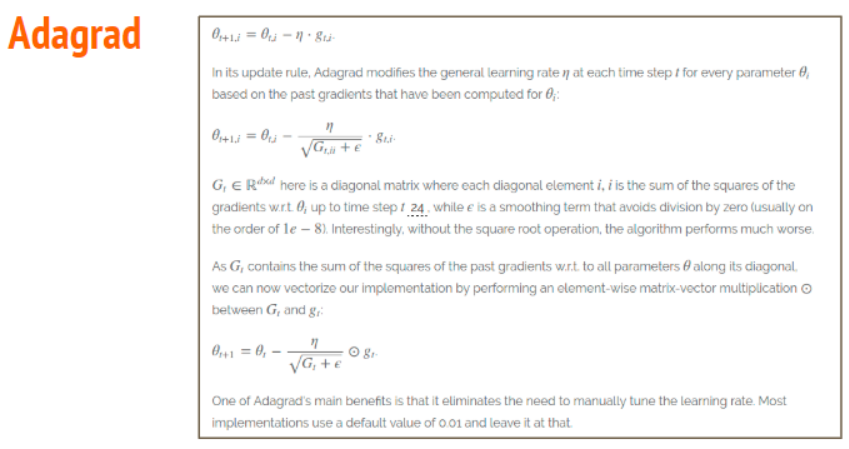

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [ ]:
dim = 1 * 9 + 1
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)
w

# **Testing**

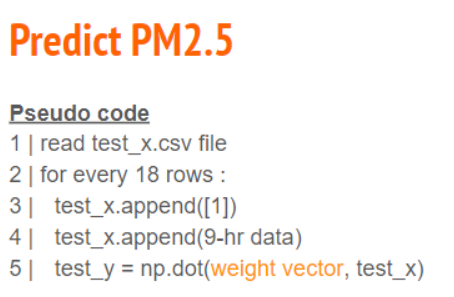

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [ ]:
testdata = pd.read_csv('/kaggle/input/week8data/test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 1*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i + 9, :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

# **Prediction**

說明圖同上

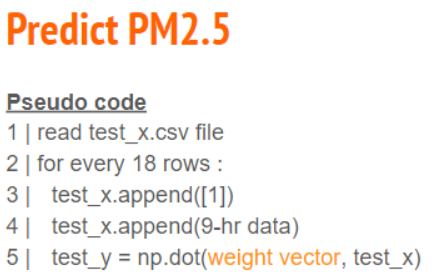

有了 weight 和測試資料即可預測 target。

In [ ]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
ans_y

# **Evaluate**

利用RMSE計算準確度。

In [ ]:
from sklearn.metrics import mean_squared_error
import math

y_true = pd.read_csv('/kaggle/input/week8data/ans.csv', header = None, encoding = 'big5')
y_true = y_true[1].drop(0)
y_true = y_true.to_numpy().astype(float)

result = math.sqrt(mean_squared_error(y_true, ans_y))
result